In [96]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

class DALIDataloader(DALIGenericIterator):
    def __init__(self, pipeline, size, batch_size, output_map=["data"], auto_reset=True, onehot_label=False):
        self.size1 = size
        self.batch_size = batch_size
        self.onehot_label = onehot_label
        self.output_map = output_map
        super().__init__(pipelines=pipeline, size=size, auto_reset=auto_reset, output_map=output_map)

    def __next__(self):
        if self._first_batch is not None:
            batch = self._first_batch
            self._first_batch = None
            return batch
        data = super().__next__()[0]
        return data[self.output_map[0]]
    
    def __len__(self):
        if self.size1%self.batch_size==0:
            return self.size1//self.batch_size
        else:
            return self.size1//self.batch_size+1
        


In [53]:
path

'../../storage/inpainting-dataset/'

<nvidia.dali.ops.python_op_factory.<locals>.Operator at 0x7fe7a411e128>

In [93]:
import os
import sys
import time
import torch
import pickle
import numpy as np
import nvidia.dali.ops as ops
from torchvision import datasets
from sklearn.utils import shuffle
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
import torchvision.transforms as transforms

IMAGENET_MEAN = [0.49139968, 0.48215827, 0.44653124]
IMAGENET_STD = [0.24703233, 0.24348505, 0.26158768]
IMAGENET_IMAGES_NUM_TRAIN = len(training_set_list)
IMAGENET_IMAGES_NUM_TEST = 50000
IMG_DIR = '../../storage/inpainting-dataset/'
TRAIN_BS = 256
TEST_BS = 200
NUM_WORKERS = 4
VAL_SIZE = 16
CROP_SIZE = 224

class HybridTrainPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data_dir, crop, dali_cpu=False, local_rank=0, world_size=1):
        super(HybridTrainPipe, self).__init__(batch_size, num_threads, device_id, seed=12 + device_id)
        dali_device = "gpu"
        self.input = ops.FileReader(file_root=data_dir, shard_id=local_rank, num_shards=world_size, random_shuffle=True)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.res = ops.RandomResizedCrop(device="gpu", size=crop, random_area=[0.08, 1.25])
        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            image_type=types.RGB,
                                            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                            std=[0.229 * 255, 0.224 * 255, 0.225 * 255])
        self.coin = ops.CoinFlip(probability=0.5)
        print('DALI "{0}" variant'.format(dali_device))

    def define_graph(self):
        rng = self.coin()
        self.jpegs = self.input(name="Reader")
        self.jpegs = self.jpegs[0]
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmnp(images, mirror=rng)
        return output


class HybridValPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data_dir, crop, size, local_rank=0, world_size=1):
        super(HybridValPipe, self).__init__(batch_size, num_threads, device_id, seed=12 + device_id)
        self.input = ops.FileReader(file_root=data_dir, shard_id=local_rank, num_shards=world_size,
                                    random_shuffle=False)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.res = ops.Resize(device="gpu", resize_shorter=size, interp_type=types.INTERP_TRIANGULAR)
        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(crop, crop),
                                            image_type=types.RGB,
                                            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                            std=[0.229 * 255, 0.224 * 255, 0.225 * 255])

    def define_graph(self):
        self.jpegs= self.input(name="Reader")
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmnp(images)
        return output


In [94]:
pip_train = HybridTrainPipe(batch_size=TRAIN_BS, num_threads=NUM_WORKERS, device_id=0, data_dir=IMG_DIR, crop=CROP_SIZE, world_size=1, local_rank=0)


DALI "gpu" variant


1743042

In [95]:
train_loader = DALIDataloader(pipeline=pip_train, size=IMAGENET_IMAGES_NUM_TRAIN, batch_size=TRAIN_BS, onehot_label=True)


/usr/local/lib/python3.6/dist-packages/nvidia/dali/plugin/base_iterator.py:124: Warning: Please set `reader_name` and don't set last_batch_padded and size manually  whenever possible. This may lead, in some situations, to miss some  samples or return duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


In [92]:
for i,data in enumerate(train_loader):
    img=data 
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

In [90]:
img.shape

torch.Size([256, 3, 224, 224])

In [31]:
# pip_test = HybridValPipe(batch_size=TEST_BS, num_threads=NUM_WORKERS, device_id=0, data_dir=IMG_DIR+'/val', crop=CROP_SIZE, size=VAL_SIZE, world_size=1, local_rank=0)
# test_loader = DALIDataloader(pipeline=pip_test, size=IMAGENET_IMAGES_NUM_TEST, batch_size=TEST_BS, onehot_label=True)

DALI "gpu" variant


AttributeError: can't set attribute

In [ ]:
if __name__ == '__main__':
    # iteration of DALI dataloader

    # print("[DALI] train dataloader length: %d"%len(train_loader))
    # print('[DALI] start iterate train dataloader')
    # start = time.time()
    # for i, data in enumerate(train_loader):
    #     images = data[0].cuda(non_blocking=True)
    #     labels = data[1].cuda(non_blocking=True)
    # end = time.time()
    # train_time = end-start
    # print('[DALI] end train dataloader iteration')

    print("[DALI] test dataloader length: %d"%len(test_loader))
    print('[DALI] start iterate test dataloader')
    start = time.time()
    for i, data in enumerate(test_loader):
        images = data[0].cuda(non_blocking=True)
        labels = data[1].cuda(non_blocking=True)
    end = time.time()
    test_time = end-start
    print('[DALI] end test dataloader iteration')
    # print('[DALI] iteration time: %fs [train],  %fs [test]' % (train_time, test_time))
    print('[DALI] iteration time: %fs [test]' % (test_time))


    # iteration of PyTorch dataloader
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(CROP_SIZE, scale=(0.08, 1.25)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dst = datasets.ImageFolder(IMG_DIR+'/train', transform_train)
    train_loader = torch.utils.data.DataLoader(train_dst, batch_size=TRAIN_BS, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    transform_test = transforms.Compose([
        transforms.Resize(VAL_SIZE),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    test_dst = datasets.ImageFolder(IMG_DIR+'/val', transform_test)
    test_iter = torch.utils.data.DataLoader(test_dst, batch_size=TEST_BS, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
    # print("[PyTorch] train dataloader length: %d"%len(train_loader))
    # print('[PyTorch] start iterate train dataloader')
    # start = time.time()
    # for i, data in enumerate(train_loader):
    #     images = data[0].cuda(non_blocking=True)
    #     labels = data[1].cuda(non_blocking=True)
    # end = time.time()
    # train_time = end-start
    # print('[PyTorch] end train dataloader iteration')

    print("[PyTorch] test dataloader length: %d"%len(test_loader))
    print('[PyTorch] start iterate test dataloader')
    start = time.time()
    for i, data in enumerate(test_loader):
        images = data[0].cuda(non_blocking=True)
        labels = data[1].cuda(non_blocking=True)
    end = time.time()
    test_time = end-start
    print('[PyTorch] end test dataloader iteration')
    # print('[PyTorch] iteration time: %fs [train],  %fs [test]' % (train_time, test_time))
    print('[PyTorch] iteration time: %fs [test]' % (test_time))

In [9]:
path = "../../storage/inpainting-dataset/"

In [32]:
len(training_set_list)

1743042

In [11]:
# train_loader = dataset.get_train_loader()

In [17]:
training_set_list = [path+"/train/"+i for i in os.listdir(path+"/train")]

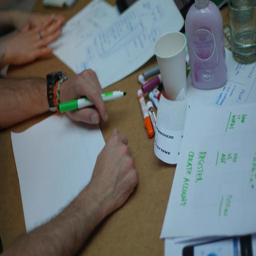

In [18]:
from PIL import Image
Image.open(training_set_list[0])